This file reads the generation data from the AUSGRID dataset and stores it in usable way for the Grid processing.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set file names
org_file = 'org_data/Solar-home-half-hour-data-1-July-2012-to-30-June-2013-AUSGRID/2012-2013-Solar-home-electricity-data-v2.csv'
export_file = 'generation_ausgrid.csv'

# Load the data from the original file
df = pd.read_csv(org_file,skiprows=1)

# Drop the row quality column since it contains only nans
df = df.drop(columns=['Row Quality'])

In [3]:
# Get index from first data point
df_temp = df.where(df['Customer'] == df['Customer'][0]).dropna()

def swap_date(date_string, time_string=''):
    """Function to give date in correct way for pd.date_range"""
    arr = date_string.split('/')
    tmp = arr[0]
    arr[0] = arr[2]
    arr[2] = tmp
    ret_string = '-'.join(arr)
    if time_string != '':
        ret_string = ret_string + ' ' + time_string
    return ret_string

# Set start and end date
start_date = swap_date(df_temp['date'].iloc[0])
end_date = swap_date(df_temp['date'].iloc[-1])
# Create DateIndex
idx = pd.date_range(start=start_date,end=end_date,freq='30T')

# Create empty pandas DataFrame
df_store = pd.DataFrame(index=idx)

In [4]:
# List of customers unique
customers = np.unique(df['Customer'].values)

# List of all time keys
time_keys = ['0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00',
       '4:30', '5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30',
       '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30',
       '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
       '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '0:00']

# Loop through all customers
for num in customers:
    # Create empty column in store DataFrame
    df_store[str(num)] = np.zeros(df_store.shape[0])
for row in range(df.shape[0]):
    num = df['Customer'].iloc[row]
    # Check if row corresponds to generation and not consumption
    if df['Consumption Category'].iloc[row] != 'GG':
        continue
    # For each time point at that day
    for time_key in time_keys:
        # Create datetime obejct
        time = pd.Timestamp(swap_date(df['date'].iloc[row],time_key))
        try: # Finding the point in the storage 
            idx = df_store.index.get_loc(time)
        except: # If not found it might be day 30-06
            if time.day != 30:
                print('Could not find index for time: ' + str(time))
        df_store[str(num)].iloc[idx] += df[time_key].iloc[row]
df_store.to_csv(export_file)

In [19]:
# Test import
df = pd.read_csv(export_file)
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df = df.set_index('Unnamed: 0')

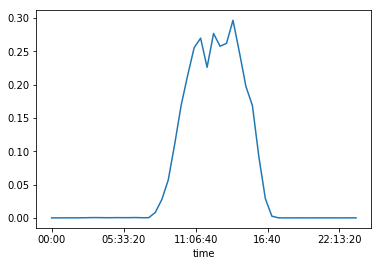

In [45]:
# Plot average production for first day
avg_prod = df.iloc[0:48,:].mean(axis=1)
time = pd.Series(avg_prod.index)
for i in range(time.shape[0]): time[i] = time[i].time()
plt.plot(time,avg_prod)

AttributeError: 'datetime.time' object has no attribute 'time'